Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: MIT-0

# 2 - Open Domain Question Answering
In this notebook we will be exploring together how to get a Large Language Model (LLM) to generate and run a graph query, specifically openCypher, from a natural language question.  We will then use this information to run a templated openCypher query against an Amazon Neptune database. To accomplish this we will be using [LlamaIndex](https://www.llamaindex.ai/) and the [`TextToCypherRetriever`](https://docs.llamaindex.ai/en/stable/module_guides/indexing/lpg_index_guide/#texttocypherretriever) to leverage Amazon Bedrock to process and answer the question.

The diagram below shows the common flow between a user, the LlamaIndex helper classes, an LLM, and Amazon Neptune.<br><br>

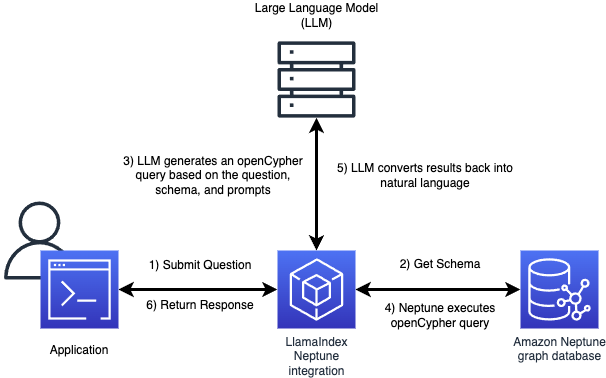

By the end of this notebook we will have all the knowledge we need to complete updating our chatbot application's Open Domain Question Answering functionality.

## Imports & Setup
The examples that follow are built using a few classes provided by LlamaIndex. We first need to import them.  We will also pull some configuration information from the notebook and get the graph identifier for our Neptune Analytics graph for later use.

In [ ]:
%pip install -qqq llama-index==0.11.16 llama-index-llms-bedrock llama-index-graph-stores-neptune llama-index-embeddings-bedrock llama-index-readers-file

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
# Configure LlamaIndex code
from llama_index.llms.bedrock import Bedrock
from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.core.prompts import PromptTemplate
from llama_index.core import (
    StorageContext,
    Settings,
)
from llama_index.graph_stores.neptune import (
    NeptuneAnalyticsPropertyGraphStore,
    NeptuneQueryException
)

from llama_index.core import Settings
from llama_index.graph_stores.neptune import NeptuneAnalyticsPropertyGraphStore
from IPython.display import Markdown, display
import json

# Retrieve the configuration information for the notebook
import graph_notebook as gn
config = gn.configuration.get_config.get_config()
host = config.host.split('.')[0]

# Set environment variable for host for Streamlit App
import os
os.environ["HOST"] = host

# Setup nest to allow for reusing the event loop by LlamaIndex
# This is a required step when running in a Jupyter Notebook
import nest_asyncio
nest_asyncio.apply()

## Loading Data
Running the cell below will remove all data from the current graph and load the SBOM data to prepare the graph for running the remaining cells in the notebook.  This query also removes unused nodes and edges that are only used in notebook 4 when we are working on a graph enhanced RAG, they will be added at that time.   

In [ ]:
%%oc
MATCH (n) DETACH DELETE n
WITH collect(n) as cnt
CALL neptune.load({format: 'csv', source: 's3://aws-neptune-customer-samples-us-west-2/workshops/building_genai_apps_using_neptune/sbom_data/',format: 'csv'})
YIELD totalRecords
MATCH (n) 
WHERE n:__Node__ OR n:Chunk OR n.entity OR n.__Entity__
DETACH DELETE n 
WITH totalRecords, count(n) as cnt                
RETURN 'Success'

### The LLM we want to use today

In this notebook we will be using the Claude V3 Sonnet Large Language Model supported by Amazon Bedrock.

In [ ]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
llm = Bedrock(model=model_id)

Settings.llm = llm

print(llm.model)

### Connect to the graph containing the data we want to query

We need to create a connection between LlamaIndex and the graph containing our SBOM data. As part of making this connection, the LlamaIndex classes will query the graph database (Neptune) and derive the schema of the graph. That schema will be used as part of the prompting that the model receives when we ask it to generate queries from questions.

In [ ]:
graph_store = NeptuneAnalyticsPropertyGraphStore(
    graph_identifier = host
)
print(graph_store.get_schema_str())

## Now we are ready to ask some questions


LlamaIndex provides default prompts and templates, but they can be overridden as needed to better suit a particular use case.  

Let's start out by trying some of the default templates and then we can look at how we can use some prompt engineering to improve the results.

To start, we create a LlamaIndex `TextToCypherRetriever` so that we can have the LLM generate Cypher queries for us based on the prompts that we provide, and the graph schema that was computed above.  When creating a `TextToCypherRetriever` there are a variety of different required and optional parameters you can provide

>**graph_store** (PropertyGraphStore):
            The graph store to retrieve data from.
            
>**llm** (Optional[LLM], optional):
            The language model to use. Defaults to Settings.llm.
            
>**text_to_cypher_template** (Optional[Union[PromptTemplate, str]], optional):
            The template to use for the text-to-cypher query. Defaults to None.
            
>**response_template** (Optional[str], optional):
            The template to use for the response. Defaults to None.
            
>**cypher_validator** (Optional[callable], optional):
            A callable function to validate the generated Cypher query. Defaults to None.
            
>**allowed_query_fields** (Optional[List[str]], optional):
            The fields to allow in the query output. Defaults to ["text", "label", "type"].
            
>**include_raw_response_as_metadata** (Optional[bool], optional):
            If True this will add the query and raw response data to the metadata property. Defaults to False.
            
>**summarize_response** (Optional[bool], optional):
            If True this will run the response through the provided LLM to create a more human readable
            response, If False this uses the provided or default response_template. Defaults to False.
            
>**summarization_template** (Optional[str], optional):
            The template to use for summarizing the response. Defaults to None.


By default the responses to a question will use a template, provided by `response_template`, to return the data in a specified format.  Let's start by creating a retriever with only the minimim required parameter, the `graph_store`, which we will set to our graph.

In [ ]:
from llama_index.core.indices.property_graph import TextToCypherRetriever

cypher_retriever = TextToCypherRetriever(graph_store)
print(f"Ready to generate queries on graph {cypher_retriever._graph_store.graph_identifier}")

Let's try a simple question based on our SBOM data model.  

**Note** - This may take 20-25 seconds to run this query due to Bedrock account limits on this account limiting the rate of LLM calls.

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here to view the schema of our graph</i></b></summary>
As a reminder, here is the data model for our SBOM data.

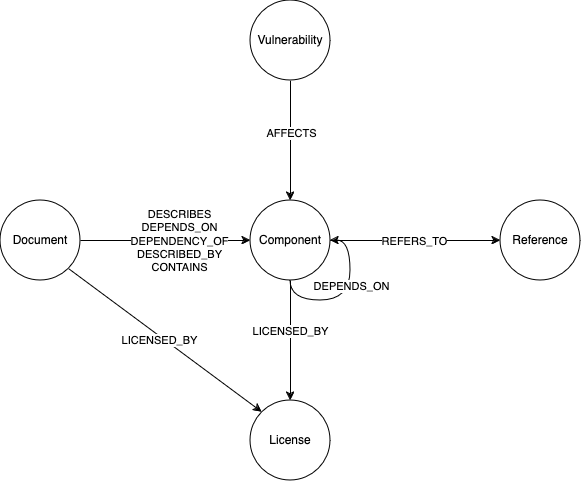

**Node Types**
* Document - This represents the SBOM document as well as the metadata associated with that SBOM.
* Component - This represents a specific component of a software system.
* Reference - This represents a reference to any external system which the system wanted to include as a reference. This can range from package managers, URLs to external websites, etc.
* Vulnerability - This represents a specific known vulnerability for a component.
* License - The license for the component or package.

**Edge Types**
* DESCRIBES/DEPENDS_ON/DEPENDENCY_OF/DESCRIBED_BY/CONTAINS - This represents the type of relationship between a Document and a Component in the system.
* REFERS_TO - This represents a reference between a Component and a Reference
* AFFECTS - This represents that a particular Component is affected by the connected Vulnerability

To run a question through this process we use the `retrieve` method of our retriever and pass it the question.
    </details>
</div>

In [ ]:
result = cypher_retriever.retrieve("Find me the number of vulnerabilties")
print(result)

<div class="alert alert-warning">
    
<details>
    <summary>
        <strong>⚠️ Warning</strong> - Click here if you see an <code>AccessDeniedException</code>
    </summary>
If you see an exception like this:
    
<code>AccessDeniedException: An error occurred (AccessDeniedException) when calling the InvokeModel operation: You don't have access to the model with the specified model ID.</code>
    
Please go back to the introduction and ensure that you have enabled access to our models (Titan Embeddings V2 and Anthropic Claude v3 Sonnet in Amazon Bedrock.

</details>
</div>


Note the result is an array of `NodeWithScore` objects. These objects contain the query that the model generated and the results that Neptune returned after running the query against our graph data.  As we stated above, the default behavior for the `TextToCypherRetriever` is to take the results and return them in a specified format. 

Let's print out only the result of our question as text.

In [ ]:
print(result[0].get_text())

We can also return the entire object as JSON.

In [ ]:
print(result[0].to_json())

Now it's your turn, ask a few questions to see how it impacts the output format.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Try several different questions to see how the queries are generated.
</div>

<strong>Note:</strong> Query generation using LLMs is not deterministic so multiple runs of the same question may generate different queries

<div class="alert alert-block alert-warning"> 
<details>
    <summary>💡 <b><i>Click here for suggested questions!</i></b></summary>

Suggested Questions:
    
<ul> 
    <li> "Find me the number of components" </li>
    <li> "Find me the average number of vulnerabilities for a component" </li>
    <li> "Find me the average number of components per document" </li>
</ul>
    
</details>
</div>


In [ ]:
try:
    result = cypher_retriever.retrieve("<INSERT QUESTION HERE>")
    print(result)
except NeptuneQueryException as e:
    print(e)

## Extracting the generated query and the response from Neptune

As we have seen the default behavior of the `TextToCypherRetriever` is to provide a templated response.  The results can also be returned to us as a JSON object (and a few other formats) but we still need to parse out the query and response from the returned values.

In many scenarios you may want to return just the generated query and raw data results.  With the `TextToCypherRetriever` we can set the `include_raw_response_as_metadata` property to `True`, which will include the raw results as metadata in our `NodeWithScore` object. Let's set that property and see how it impacts our results.

In [ ]:
cypher_retriever.include_raw_response_as_metadata=True
result = cypher_retriever.retrieve("Find me the number of vulnerabilties")
print(result[0].metadata)

Now, let's display this in an easier to read form.

In [ ]:
print(json.dumps(result[0].metadata, indent=2))

From the metadata we can see not only the response from the database, but also the query that was generated by the LLM.  To see just the openCypher query generated run the cell below.

In [ ]:
print(result[0].metadata['query'])

## Asking the LLM to summarize the answer
So far we have a way to prompt the model with a graph schema and a question, ask it to write a query for us, and to have Neptune execute that query. These results are all the raw data, however if we are building an interactive chat experience where the human is asking natural language questions, ideally we also want the responses in natural language. 

To achieve this we can use the `TextToCypherRetriever` to provide a human readable response.  Setting the `summarize_response` and optionally the `summarization_template`, the system automatically executes the query and sends the results to the LLM to get back a human readable response.

In [ ]:
cypher_retriever.summarize_response=True
result = cypher_retriever.retrieve("Find me the number of vulnerabilities")
print(result[0].get_text())

Now it's your turn to ask a few questions and see how the responses are returned.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Ask several different questions and observe the summarized response. 
</div>

In [ ]:
try:
    result = cypher_retriever.retrieve("<INSERT QUESTION HERE>")
    print(result[0].get_text())
except NeptuneQueryException as e:
    print(e)

## Putting it all together
Now that we have all the pieces, we can combine them to produce a question and answer method that hides the complexity behind a very simple API that an application will use for interacting with LlamaIndex, Amazon Bedrock, and Neptune.

For this next section we are going to be modifying an incomplete version of our chatbot application to have it function for open domain question and answering.

In Jupyter, navigate to the `app` subfolder and click on the file `OpenDomainQA.py` to edit it.  
<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
Please use the `OpenDomainQA.py` fileThere is also a file named `OpenDomainQA.py.optional`, which is only used as part of the optional section.

</div>

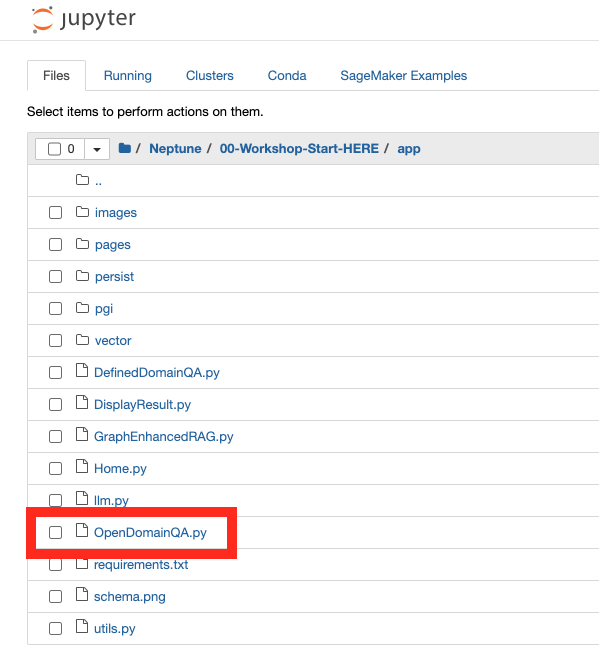

Once you have loaded that file you will need to update the code in two places:

1. In the `__init__()` method, please modify the following lines to create a `TextToCypherRetriever` and assign it to the variable `self.cypher_retriever`

```
        # Configure the TextToCypher Retriever
        self.cypher_retriever = {}  # UPDATE CODE HERE
```

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅  <b><i>Click here to check your answer</i></b></summary>

<code>
        self.cypher_retriever = TextToCypherRetriever(
            self.graph_store, include_raw_response_as_metadata=True
        )
</code>

</details>
</div>


2. * In the `run_natural_language_query()` method, please modify the following lines to run the `retrieve()` method on our `TextToCypherRetriever` and assign it to the variable `resp`

```
        # Run the retrieve method on the TextToCypher Retriever
        resp = {}  # Update CODE HERE
```

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅  <b><i>Click here to check your answer</i></b></summary>

<code>
        resp = self.cypher_retriever.retrieve(prompt)
</code>

</details>
</div>

Once you have made these changes you can proceed on to the cells below, which will run our Streamlit application locally so you can test out your application.  Once it is running please click on the "Click here to open the sample application" link to open a new browser tab pointing to your running application.

In [ ]:
%pip install -qqq -r ./app/requirements.txt jupyter-server-proxy jupyter-rsession-proxy

<div class="alert alert-warning">
<strong>⚠️ Notice</strong><hr>
    
If a <code>Note</code> or <code>Error</code> message appears after installing these packages, you can safely ignore these version incompatabilities and/or message to restart the notebook kernel.
</div>

In [ ]:
import subprocess

# Fetch the CloudFormation stack output
output_value = subprocess.check_output(
    ["aws", "cloudformation", "describe-stacks",
     "--stack-name", "workshop",
     "--query", "Stacks[0].Outputs[?OutputKey==`NotebookInstance`].OutputValue | [0]",
     "--output", "text"]
).decode().strip()
output_value += "proxy/8501/Open_Domain_Question_Answering"

# Display the clickable link to the chat app
from IPython.display import Markdown

display(Markdown(f"<a href={output_value} target=\"_blank\">Click here to open the sample application</a>"))

!streamlit run ./app/Home.py --browser.gatherUsageStats false --browser.serverAddress 0.0.0.0 > /dev/null

<div class="alert alert-block alert-danger"> 
<strong>🛑</strong> You must stop the cell execution manually using the stop button on the control bar before moving on to the rest of this notebook.
</div>

## Summary

In this section, we demonstrated how an LLM can use the schema of the graph to generate and run a graph query to satisfy a natural language question.  

One of the impressive aspects of this approach is that we're able to get the desired results without having to deeply learn the intricacies of complex query languages like openCypher. Up to this point, we've been progressing smoothly, with our natural language queries successfully translating into the appropriate structured graph queries.

However, it's important to recognize the inherent nature of large language models (LLMs) - they will not always generate the correct query, even if the original natural language question was clear. When the generated query does not produce the expected results, we'll need to employ techniques such as query validation, prompt tuning, and query rewriting to troubleshoot and refine the process.  Below we have added an optional section that goes through each of these techniques.

## Next Steps
We have completed the main sections of this notebook, now you can either continue to the next one, or look at the optional sections below to learn more about this topic.

**Continue to part 3 of the workshop in the [next notebook](3-Defined-Domain-Question-Answering.ipynb).**

---
# Optional - Improving Query Generation on a path to production

As you have likely seen above, query generation with LLMs does decently well but for a production use case we need better consistency with the results that are created.  In this (optional) section we will review a few options for improving the introspection, quality, and consistency of query generation.  Let's start with the first technique, prompt engineering.

## Viewing our Graph Schema

We can examine the schema as retrieved by LlamaIndex from Neptune. It contains information about nodes, edges, properties (with their types), labels, and the relationships between nodes with a given label.  This may take a few moments to complete as the schema is collected from the graph.

In [ ]:
res = graph_store.get_schema()
print(json.dumps(res, indent=2))

## Managing the response format
LlamaIndex uses [Prompts](https://docs.llamaindex.ai/en/stable/module_guides/models/prompts/) as a fundamental concept that gives LLMs the context needed to perform a task.  LlamaIndex provides constructs to allow users to further customize the behavior of the framework. In general, the prompt is a string object where certain predefined variables are added in at runtime, these variables are specified by using curly braces `{}` around the variable name.  In this case we have two variables, `query` and `response` that we can use.

Now let's customize the response format.

In [ ]:
cypher_retriever.response_template="This is the response from the graph: {response}"
result = cypher_retriever.retrieve("Find me the number of vulnerabilities")
print(result[0].get_text())

Now it's your turn, try a few variations of the template to see how it impacts the output format.

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Create several example templates and see how they change the provided response format. 
</div>

In [ ]:
cypher_retriever.response_template="<INSERT YOUR TEMPLATE HERE>"
result = cypher_retriever.retrieve("Find me the number of vulnerabilities")
print(result[0].get_text())

## Customizing our summarization template

In addition to the response format we can also customize the summarization template that is used to provide human readable responses.  Let's start by printing out the current template, which we will also store into a variable to be able to reset our template later if needed.

In [ ]:
default_summarization_text = cypher_retriever.summarization_template.template
print(default_summarization_text)

Now that we know see the template let's add a line to instruct the LLM to end all lines with a polite greeting and see how that impacts our response.

In [ ]:
cypher_retriever.summarization_template.template = (cypher_retriever.summarization_template.template + 
"End all responses with 'Thank you'")
result = cypher_retriever.retrieve("Find me the number of vulnerabilities")
print(result[0].get_text())

Now it's your turn, try a few variations of the template to see how it impacts the output format.  Remember you can always set the template back to the default value by setting the variable we saved earlier.

`cypher_retriever.summarization_template.template = default_summarization_text`

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Create several example summarization templates and see how they change the summarized response. 
</div>

In [ ]:
cypher_retriever.summarization_template.template = 'INSERT YOUR TEMPLATE HERE'
result = cypher_retriever.retrieve("Find me the number of vulnerabilities")
print(result[0].get_text())

## Query generation prompt engineering

In the sections above we showed how you can do prompt engineering to alter the response and summarization templates.  The same concepts can be applied to the query generation template, in the `text_to_cypher_template` property.  Amazon Neptune supports the open specification openCypher query language, however LLM's are trained on public data, much of which is based on the proprietary Cypher query language.  While openCypher and Cypher are similar, there are multiple differences, such as date/time handling and RegEx matching, that are not included in the openCypher specification.  With some clever prompt engineering we can add hints to the LLM to instruct it not to use the unsupported features.

Let's first take a look at the default template.

In [ ]:
cypher_retriever = TextToCypherRetriever(graph_store)
print(cypher_retriever.text_to_cypher_template.template)

Let's see what it looks like if we ask a question that will use one of these features, such as RegEx.

In [ ]:
try:
    result = cypher_retriever.retrieve("Find me the name of components like 'python'")
except NeptuneQueryException as e:
    print(e)
print(result[0].get_text())

Assuming that the LLM wrote the expected query, then we should have seen an error was returned stating that it was trying to use an unsupported feature `RegexMatch`.

To address this issue lets add an instruction to our LLM to not use RegEx.  We achieve this by appending additional instructions to the end of the default template.  In this case we will suggest that it use a lowercase CONTAINS search instead

In [ ]:
cypher_retriever.text_to_cypher_template.template = cypher_retriever.text_to_cypher_template.template + """
\nDo not use RegexMatch queries, use a lowercase CONTAINS search instead.\n
"""
print(cypher_retriever.text_to_cypher_template.template)

In [ ]:
try:
    result = cypher_retriever.retrieve("Find me the name of components like 'python'")
    print(result[0].get_text())
except NeptuneQueryException as e:
    print(e)

Assuming our LLM listened to our suggestion (🤞) the query should have returned several records.  If we look at the query that was generated then we should see something like `WHERE LOWER(c.name) CONTAINS 'python'` in the query.

Let's take a look at another common tripping point, property names.  LLMs can struggle to properly reference property names if they contain periods (`.`) in the name.  This is not a difference between openCypher and Cypher but more an artifact of the flexibility of the query language.  In openCypher, you can reference property names that contain a period by surrounding the property name with backticks, otherwise it will treat the names after the period as a sub-property of a map. 

Let's take a look at this challenge.

In [ ]:
try:
    result = cypher_retriever.retrieve("Find me the count of vulnerabilities grouped by severity")
    print(result[0].get_text())
except NeptuneQueryException as e:
    display(e)

Let's add another suggestion to our template to handle this scenario.

In [ ]:
cypher_retriever.text_to_cypher_template.template = cypher_retriever.text_to_cypher_template.template + """
Wrap all property names in backticks except for label names.\n
"""
try:
    result = cypher_retriever.retrieve("Find me the count of vulnerabilities grouped by severity")
    print(result[0].get_text())
except NeptuneQueryException as e:
    print(e)

<div class="alert alert-info">
    <strong>🛠️ Your task</strong>: Try out a few additional queries and add some additional instructions to the template. 
</div>

In [ ]:
try:
    result = cypher_retriever.retrieve("<INSERT YOUR QUERY HERE>")
    print(result[0].get_text())
except NeptuneQueryException as e:
    print(e)

<div class="alert alert-block alert-success"> 
<details>
    <summary>✅  <b><i>Click here to check your answer</i></b></summary>

There is not a single correct answer here but below is an example that shows how to add suggestions for some of the more common challenges.
<code>
    cypher_retriever.text_to_cypher_template.template + """
        Wrap all property names in backticks except for label names.\n
        When using property names, ensure that the associated variable name is also used.\ncypher_retriever.text_to_cypher_template.template
        Ensure that all property names are used in conjunction with the correct node or relationship alias.\n
        All comparisons with string values should be done in lowercase.\n
        Do not use RegexMatch queries, use a lowercase CONTAINS search instead.\n
        Ensure that the relationship directions are correct according to the provided schema.\n
        If you don\'t know how to write a query given the prompt return \'I don\'t know\'"""

</code>

</details>
</div>

## Query schema validation

Another common challenge that occurs when LLMs generate queries is that they do not always get the edge directions correct.  To help correct this we can leverage the `cypher_validator` property of the `TextToCypherRetriever` along with the [`CypherQueryCorrector`](https://api.python.langchain.com/en/latest/chains/langchain.chains.graph_qa.cypher_utils.CypherQueryCorrector.html) code from [Langchain](https://www.langchain.com/) to perform some validation checks and corrections for edge directions in generated queries.

**Note:** Consistently reproducing an incorrect edge direction is challenging due to the non-determenistic nature of query generation.  For this section you will just need to trust us that this helps.

The first step we need to do is to get the schema from our graph, as shown before, and then translate that into the format needed by LangChain ([here](https://api.python.langchain.com/en/latest/chains/langchain.chains.graph_qa.cypher_utils.Schema.html#langchain.chains.graph_qa.cypher_utils.Schema)).  The code to do this is supplied below.

In [ ]:
def format_schema():
    """This retrieves the schema from the graph store and converts it to a LangChain Schema

    Returns:
        Schema: A List of LangChain Schema object
    """
    edge_schema = []
    for i in graph_store.get_schema()["triples"]:
        i = (
            i.replace("(:`", "")
            .replace("`)", "")
            .replace("[:`", "")
            .replace("`]", "")
            .replace(">", "")
        )
        parts = i.split("-")
        if len(parts) == 3:
            edge_schema.append(
                Schema(left_node=parts[0], relation=parts[1], right_node=parts[2])
            )

    return edge_schema

Now that we have the procedure to get the schema we can supply this as an input to our `CypherQueryCorrector` method.  At runtime this procedure will be called for each query generated.  This will then compare the generated query against the supplied schema and attempt to correct the relationship direction of any edge.

In [ ]:
from langchain_community.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

cypher_retriever.cypher_validator=CypherQueryCorrector(format_schema())

In [ ]:
try:
    result = cypher_retriever.retrieve("Which component is affected by the most vulnerabiltiies")
    print(result[0].get_text())
except NeptuneQueryException as e:
    print(e)

## Query error rewriting

The final optimization we are going to discuss as part of this workshop is query error rewriting.  This optimization takes our prompt engineering efforts one step further and provides the LLM with the incorrect query and error message as part of the query generation prompt.  This provides additional context to the LLM during query generation and allows better query generation.  Let's start be defining a few variables, specifically lets get a copy of our query generation template, a rewrite template based on the default template plus additional instructions to pass in incorrect query and error, and finally let's set a max number of retries, so we don't get ourselves into an infinite loop.  

In [ ]:
DEFAULT_TEXT_TO_CYPHER_TEMPLATE = cypher_retriever.text_to_cypher_template.template
REWRITE_TEXT_TO_CYPHER_TEMPLATE = cypher_retriever.text_to_cypher_template.template + """
    The previous Cypher statement is:\n{previous_cypher}\n
    The previous error message is:\n{error_message}\n\n
    Wrap all property names in backticks except for label names.\n
    When asking for the component id return the id().\n
    Ensure that all property names are used in conjunction with the correct node or relationship alias.\n
    All comparisons with string values should be done in lowercase.\n
    Do not use RegexMatch queries, use a lowercase CONTAINS search instead.\n
    Ensure that the relationship directions are correct according to the provided schema.\n
    If you don\'t know how to write a query given the prompt return \'I don\'t know\'
    """
MAX_RETRIES = 3

Next, let's make a method to return the correct prompt based on our scenario.  We do this by creating a method that takes in the query and error, and if one exists send back the rewrite template but if no errors exist then send our default template.

In [ ]:
def determine_prompt(query: str, error_msg: str):
    """This determines which prompt template to use based on the error message and query for rewriting the query

    Args:
        query (str): The previous cypher statement that failed to execute
        error_msg (str): The error message returned by the failed query

    Returns:
        PromptTemplate: The appropriate prompt template based on the error message and query
    """
    template = cypher_retriever.text_to_cypher_template
    if query is None or error_msg is None:
        template.template = DEFAULT_TEXT_TO_CYPHER_TEMPLATE
        return template
    else:
        # Use Partial Formatting on the template to add the previous cypher statement and error
        # https://docs.llamaindex.ai/en/stable/examples/prompts/advanced_prompts/#1-partial-formatting
        template.template = REWRITE_TEXT_TO_CYPHER_TEMPLATE
        rewrite_template = template.partial_format(
            previous_cypher=query, error_message=error_msg
        )
        return rewrite_template

Now we have come to out last piece, the method that runs the query.  In this example, we have surrounded the retrieve logic we used above inside a loop.  If a specific iteration of a loop throws an error, and specifically a `NeptuneQueryException` that contains `MalformedQueryException` or `ValidationException` in the details we know that this is a retriable exception.  In those cases the error and query are parsed from the exception and fed back into the prompt to rewrite the query.  This is tried up to 3 times before the query fails.

In [ ]:
def run_natural_language_query(
    prompt: str
):
    """This takes in the prompt and runs the natural language query against the graph store

    Args:
        prompt (str): The prompt question to answer

    Returns:
        DisplayResult: An object containing the results of the query and the query itself
    """
    retry = 0
    query = None
    error_msg = None
    resp = None
    while retry < MAX_RETRIES:
        try:
            cypher_retriever.text_to_cypher_template = determine_prompt(
                query, error_msg
            )
            print(f"Query retry: {retry}")
            resp = cypher_retriever.retrieve(prompt)
            return resp[0].get_text()
        except NeptuneQueryException as e:
            print(f"Generated Query Failed with the following message: {e}")
            if "MalformedQueryException" or "ValidationException" in e.details:
                query = e.args[0]["query"]
                error_msg = e.args[0]["details"]
                retry += 1
            else:
                return "We were unable to get a valid query result for the provided question.  Please try again or modify the question."

Let's try this out and see this in action.

In [ ]:
print(run_natural_language_query("""Find me the components that have 'high' or 'critical' vulnerabilities? Group by component and severity count, order by component then by severity"""))

## Putting it all together
Now that we have all the pieces for a more production level application let's see what this looks like when we put it into action.

For this next section we are going to be modifying an incomplete version of our chatbot application to have it function for open domain question and answering.

In Jupyter, navigate to the `app` subfolder and click on the file `OpenDomainQA.py` to edit it.  Next, open the `OpenDomainQA.py.optional` file and copy and paste the contents of that file into the `OpenDomainQA.py`.  This file contains an updated version of our code that includes the three technniques described above.  Once you have pasted the contents then save the file and run the cell below to run our Streamlit app.  

In [ ]:
import subprocess

# Fetch the CloudFormation stack output
output_value = subprocess.check_output(
    ["aws", "cloudformation", "describe-stacks",
     "--stack-name", "workshop",
     "--query", "Stacks[0].Outputs[?OutputKey==`NotebookInstance`].OutputValue | [0]",
     "--output", "text"]
).decode().strip()
output_value += "proxy/8501/"

# Display the clickable link to the chat app
from IPython.display import Markdown

display(Markdown(f"<a href={output_value} target=\"_blank\">Click here to open the sample application</a>"))

!streamlit run ./app/Home.py --browser.gatherUsageStats false --browser.serverAddress 0.0.0.0 > /dev/null

## Summary

In this optional section we walked through three techniques you can use to help mitigate some of the challenges you are likely to run into when using LLMs to generate natural language queries.  Specifically we showed:

* Prompt engineering - Allows us to control the instructions sent to the LLM to get around some of the differences between public examples and the syntax supported by Neptune.
* Schema validation - One common mistake that LLMs make when generating queries is that they can provide an incorrect edge direction, which leads to the query returning incorrect results.  Schema validation compares the generated query against the graph schema and attempts to correct any issues with edge direction.
* Query error rewriting - One of the strengths of LLMs is their adaptability.  When a query errors, due to syntax issues with the generated query, we pass the generated query and the error message back to the LLM and have it try to rewrite the query.

By combining these techniques together we can start to improve our query generation capabilities.  However, we are still giving customers direct access to our graph so additional process safeguards, such as limiting users to read only access, need to be included to prevent misuse.